In [69]:
%pip install gdown
import gdown
#ethnicity
#url = "https://drive.google.com/drive/folders/1ZKMUq6U6pRw7zcP6AkGxoQVX3LnMnGXC?usp=share_link"
#gender
# url="https://drive.google.com/drive/folders/1hKgsi0EAsyDAKlVV6WEnK8LvslfLc9ME?usp=drive_link"
#age
url="https://drive.google.com/drive/folders/1B77SD7Eh9mbaoGIa7Dcaleqaee-wlMMm?usp=drive_link"
gdown.download_folder(url, quiet=True)

['/content/splitted_by_age/eyes.zip',
 '/content/splitted_by_age/mouth.zip',
 '/content/splitted_by_age/nose.zip']

**IMPORT THE NECESSARY LIBRARIES FOR THE NOTEBOOK TO WORK**

In [2]:
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
import zipfile
import shutil
from collections import defaultdict
from PIL import Image
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from torch.utils.data import  Dataset
from sklearn.model_selection import KFold
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.preprocessing import LabelEncoder

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [75]:
# Datapath Project_Biometric/Dataset
#folder_path = "splitted_dataset"
# folder_path = "splitted_by_gender"
folder_path="splitted_by_age"
for file_name in os.listdir(folder_path):

    # zipped files in the folder biometric_systems_dataset
    if file_name.endswith(".zip"):

      # full path to the zip file
      file_path = os.path.join(folder_path, file_name)

      # create folder in the same path with the name of the zip file
      extract_folder = os.path.join(folder_path, file_name.replace(".zip", ""))
      os.makedirs(extract_folder, exist_ok=True)

      # open and extract the file
      with zipfile.ZipFile(file_path, mode="r") as zip_ref:
        zip_ref.extractall(extract_folder)
      os.remove(file_path)

for folder in os.listdir(folder_path):
    dir_path = os.path.join(folder_path, folder)

    # Procedi solo se è una directory
    if os.path.isdir(folder_path):
        train_folder = os.path.join(dir_path, "train")
        test_folder = os.path.join(dir_path, "test")

        train_count = len([f for f in os.listdir(train_folder) if os.path.isfile(os.path.join(train_folder, f))]) if os.path.exists(train_folder) else 0
        test_count = len([f for f in os.listdir(test_folder) if os.path.isfile(os.path.join(test_folder, f))]) if os.path.exists(test_folder) else 0

        print(f"Cartella '{folder}':")
        print(f"  Train set: {train_count} file")
        print(f"  Test set: {test_count} file")

Cartella 'mouth':
  Train set: 18421 file
  Test set: 4610 file
Cartella 'nose':
  Train set: 18421 file
  Test set: 4610 file
Cartella 'eyes':
  Train set: 18421 file
  Test set: 4610 file


**TRYING SMOTE FOR BALANCING OUT THE DATASET**

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)  # You can adjust the random state as needed
X_resampled, y_resampled = sm.fit_resample(X_train, y_train)

**Checking the availability of the images**

In [ ]:
# def display_first_image(folder_path):
#     image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif'))]

#     if not image_files:
#         print("No images found in the specified folder.")
#         return

#     first_image_path = os.path.join(folder_path, image_files[0])

#     try:
#         img = Image.open(first_image_path)
#         plt.imshow(img)
#         plt.show()
#     except IOError:
#         print("Error opening image file:", first_image_path)

# # Replace with your actual folder path
# folder_path_eyes= "/content/splitted_dataset/eyes/train"
# folder_path_mouth = "/content/splitted_dataset/mouth/train"
# folder_path_nose = "/content/splitted_dataset/nose/train"
# display_first_image(folder_path_eyes)
# display_first_image(folder_path_mouth)
# display_first_image(folder_path_nose)

**Getting the frequencies of the labels**

In [ ]:
def get_frequencies(datapath):
  total_images=0
  # class_counts = {0: 0, 1: 0, 2: 0, 3: 0, 4: 0}
  # class_counts={0:0,1:0}
  class_counts={}
  for filename in os.listdir(datapath):
      if filename.endswith(".jpg") or filename.endswith(".png"):
          total_images += 1
          parts = filename.split('_')
          if len(parts) >= 4:
              label = int(parts[2])  # Convert label to integer
              class_counts[label] += 1
  return class_counts
#gender
# folder_path_eyes= "/content/splitted_by_gender/eyes/train"
# folder_path_mouth = "/content/splitted_by_gender/mouth/train"
# folder_path_nose = "/content/splitted_by_gender/nose/train"

#age
folder_path_eyes= "/content/splitted_by_age/eyes/train"
folder_path_mouth = "/content/splitted_by_age/mouth/train"
folder_path_nose = "/content/splitted_by_age/nose/train"

print(get_frequencies(folder_path_eyes))
print(get_frequencies(folder_path_nose))
print(get_frequencies(folder_path_mouth))

# print("Total images:", total_images)
# print("Class counts:", class_counts)

{0: 9654, 1: 8767}
{0: 9639, 1: 8782}
{0: 9692, 1: 8729}


**COMPUTING THE HISTOGRAMS FOR THE LBP**

In [70]:
def calculate_lbp(image, R=2, P=7):
    # Convert to grayscale if necessary
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    # Apply LBP operator
    lbp = local_binary_pattern(gray, P=8, R=3, method='uniform')
    #lbp = cv2.LBP(gray, neighbors, radius)

    # Calculate histogram
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(257))

    # Normalize histogram
    hist = hist.astype("float")
    hist /= hist.sum() + 1e-7
    return hist



**CREATING THE DATASET**

In [71]:
# Dataset personalizzato
class EthnicityDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.images = []
        self.labels = []
        self.features=[]


        # Scansione della cartella per ottenere i file
        for filename in os.listdir(root_dir):
            if filename.endswith(".jpg") or filename.endswith(".png"):  # Considerando immagini .jpg e .png
                self.images.append(filename)

                # Estraiamo l'etnia dalla parte finale del nome del file
                # esempio: eyes_100_1_0_20170112213001988
                parts = filename.split('_')
                if len(parts) >= 4:

                    #age
                    label=parts[1]
                    label=int(label)

                    #gender
                    # label=parts[2]
                    # label_map={"0":0,"1":1}
                    #label = parts[3]  # L'etnia è il quarto elemento (indice 3)
                    #label_map = {"0": 0, "1": 1, "2": 2, "3": 3, "4": 4}  # Mappatura delle etnie

                    label_map = {}
                    for i in range(1, 117):
                        if 1 <= i <= 5:
                            label_map[i] = 0
                        elif 6 <= i <= 12:
                            label_map[i] = 1
                        elif 13 <= i <= 20:
                            label_map[i] = 2
                        elif 21 <= i <= 35:
                            label_map[i] = 3
                        elif 36 <= i <= 50:
                            label_map[i] = 4
                        elif 51 <= i <= 75:
                            label_map[i] = 5
                        elif 76 <= i <= 90:
                            label_map[i] = 6
                        elif 91 <= i <= 116:
                            label_map[i] = 7
                    self.labels.append(label_map.get(label, -1))  # -1 se l'etnia non è trovata
        self.labels=np.array(self.labels)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_name = self.images[idx]
        image_path = os.path.join(self.root_dir, image_name)

        try:
            image = Image.open(image_path)
        except Exception as e:
            print(f"Errore nel caricamento dell'immagine {image_path}: {e}")
            return None, None

        label = self.labels[idx]
        # self.labels.append(label)
        # Calculate LBP features
        image = np.array(image)  # Convert to NumPy array for OpenCV
        feature = calculate_lbp(image)
        self.features.append(feature)  # Store features (optional)


        # Aggiungi un controllo se l'etichetta è corretta
        if label == -1:
            print(f"Errore: etichetta non trovata per {image_name}")

        return feature, label

**EXTRACTING THE FEATURES FROM THE DATASET**

In [72]:
def extract_lbp_features(dataset):
    """Extracts LBP features from a list of images.

    Args:
        images: A list of images, where each image is a NumPy array.

    Returns:
        A NumPy array of LBP features.
    """
    # # Get a list of image filenames in the directory
    # image_filenames = os.listdir(root_dir)
    # for filename in image_filenames:
    #   image_path = os.path.join(root_dir, filename)
    #   img = cv2.imread(image_path)
    #   if img is not None:
    #       lbp_features,_ = extract_lbp_features(img)
    # return np.array(lbp_features)
    features = []

    for _ in range(len(dataset)):
      image, label = dataset[_]
      # features.append(image)
      # labels.append(label)
      # features = np.array(features)
      # labels = np.array(labels)
    return np.array(dataset.features)

# # Assuming X_train and X_test are lists of image paths or NumPy arrays
# X_train_lbp = extract_lbp_features(X_train)
# X_test_lbp = extract_lbp_features(X_test)

In [73]:
def compute_class_weight(class_weight, classes, y, majority_class_weight_factor):
    # """Computes class weights based on class frequency.

    # Args:
    #     class_weight: The class weighting strategy (e.g., 'balanced').
    #     classes: A list of class labels.
    #     y: The true labels of the training data.

    # Returns:
    #     A dictionary mapping class labels to their corresponding weights.
    # """

    # if class_weight == 'balanced':
    #     # Calculate class frequencies
    #     class_counts = np.bincount(y)
    #     print(class_counts)
    #     # Calculate class weights inversely proportional to frequency
    #     class_weights = 1. / class_counts
    #     class_weights = class_weights / class_weights.sum() * len(classes)
    #     print(class_weights)
    #     class_weights = dict(enumerate(class_weights))
    # else:
    #     raise ValueError("Invalid class_weight value")
    # print(class_weights)
    # return class_weights
    if class_weight == 'balanced':
        # Calculate class frequencies
        class_counts = np.bincount(y)
        print(class_counts)
        #_, class_counts = np.unique(y, return_counts=True)

        # Identify the majority class
        majority_class = np.argmax(class_counts)

        # Calculate class weights inversely proportional to frequency
        class_weights = 1. / class_counts

        # Adjust the weight of the majority class
        class_weights[majority_class] *= majority_class_weight_factor

        # Normalize weights
        class_weights = class_weights / (class_weights.sum() * len(classes))

        class_weights = dict(enumerate(class_weights))
    else:
        raise ValueError("Invalid class_weight value")

    return class_weights

**EYES TRAINING VALIDATION AND TEST**

In [76]:
#Initialize the dataset
#gender
# full_train_dataset = EthnicityDataset(root_dir="/content/splitted_by_gender/eyes/train")
# test_dataset = EthnicityDataset(root_dir="/content/splitted_by_gender/eyes/test")

#age
full_train_dataset = EthnicityDataset(root_dir="/content/splitted_by_age/eyes/train")
test_dataset = EthnicityDataset(root_dir="/content/splitted_by_age/eyes/test")

# Extract features for all images in one line
X_train = extract_lbp_features(full_train_dataset)
y_train = full_train_dataset.labels  # Now contains numerical labels

X_test = extract_lbp_features(test_dataset)
y_test=test_dataset.labels

In [ ]:
print(y_train)

[0 0 0 ... 0 0 0]


**Triplicate the images belonging to the lowest image counting label**

# **Sampling procedure on the dataset**

In [ ]:
# ros = RandomOverSampler(sampling_strategy={2: 3500, 3: 3500, 4: 3000}, random_state=42)
# rus = RandomUnderSampler(sampling_strategy={0: 5000}, random_state=42)
# # Apply oversampling
# X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
# X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)

# **Changing the weights on the training set and producing the datasets for the models**

---



In [77]:
X_resampled=X_train
y_resampled=y_train
class_weights = compute_class_weight('balanced',  classes=np.unique(y_resampled), y=y_resampled, majority_class_weight_factor=1.5)
#class_weights = compute_class_weight('balanced', classes=np.unique(y_train), )
# Create class weights array for each sample
class_weights = np.array([class_weights[label] for label in y_resampled])

[1594  786 1153 8129 3172 2939  584   64]


In [78]:
train_data = lgb.Dataset(X_resampled, label=y_train,weight=class_weights)
test_data = lgb.Dataset(X_test, label=y_test,free_raw_data=False)

# Ensure X_train and y_train are valid NumPy arrays
if not isinstance(X_resampled, np.ndarray) or not isinstance(y_train, np.ndarray):
    raise ValueError("X_train and y_train must be NumPy arrays")
# Check for empty training data
if len(X_resampled) == 0:
    raise ValueError("X_train cannot be empty")

# **Using GridSearchCV to tune the hyperparameters**

In [ ]:
# Define the parameter grid for Grid Search
param_grid = {
    'learning_rate': [0.05, 0.1, 0.15],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'num_leaves': [31, 63, 127],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}

# Create a LightGBM classifier
model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(np.unique(y_resampled)),
    metric='multi_logloss',
    verbose=-1
)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          cv=2,
                          scoring='accuracy',
                          n_jobs=-1)
# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters
print(f"Best parameters: {grid_search.best_params_}")

# params = {
#     'objective': 'multiclass',  # Adjust for your specific task
#     'num_class': len(np.unique(y_resampled)),# Number of classes in your dataset
#     'metric': 'multi_logloss',
#     'learning_rate':  0.07,
#     'num_leaves': 31,
#     'max_depth': 6,
#     'boosting_type': 'gbdt',
#     'verbose': -1,
#     'feature_fraction': 0.8
#     # ... other hyperparameters
# }
# num_round=110
# #GridSearchCV to tune the hyperparameters
# model = lgb.train(params,
#                  train_data,
#                  num_round,
#                  valid_sets=[train_data,test_data],
#                  callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=10)])

# kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# for fold, (train_index, val_index) in enumerate(kfold.split(X_resampled, y_resampled)):
#     X_train, X_val = X_resampled[train_index], X_resampled[val_index]
#     y_train, y_val = y_resampled[train_index], y_resampled[val_index]

#     train_data = lgb.Dataset(X_train, label=y_train)
#     val_data = lgb.Dataset(X_val, label=y_val)

#     model = lgb.train(params,
#                       train_data,
#                       num_round,
#                       valid_sets=[train_data, val_data],
#                       callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=10)])

#     y_pred = model.predict(X_val, num_iteration=model.best_iteration)
#     y_pred_classes = y_pred.argmax(axis=1)

#     # Evaluate the model on the validation fold
#     print(f"Fold {fold+1} Classification Report:")
#     print(classification_report(y_val, y_pred_classes))

# y_pred = model.predict(X_test, num_iteration=model.best_iteration)
# y_pred_classes = y_pred.argmax(axis=1)
# # Evaluate the model
# print(classification_report(y_test, y_pred_classes))


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'num_leaves': 63, 'subsample': 0.8}


In [ ]:
#Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'num_leaves': 63, 'subsample': 0.8}

# **Training the model on the newly found hyperparameters and predicting the labels**

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[10]	valid_0's multi_logloss: 1.77125
[20]	valid_0's multi_logloss: 1.68517
[30]	valid_0's multi_logloss: 1.63715
[40]	valid_0's multi_logloss: 1.60807
[50]	valid_0's multi_logloss: 1.58964
[60]	valid_0's multi_logloss: 1.57811
[70]	valid_0's multi_logloss: 1.56912
[80]	valid_0's multi_logloss: 1.56264
[90]	valid_0's multi_logloss: 1.55699
[100]	valid_0's multi_logloss: 1.55198
[110]	valid_0's multi_logloss: 1.54725
[120]	valid_0's multi_logloss: 1.54372
[130]	valid_0's multi_logloss: 1.53939
[140]	valid_0's multi_logloss: 1.53537
[150]	valid_0's multi_logloss: 1.5319
[160]	valid_0's multi_logloss: 1.52845
[170]	valid_0's multi_logloss: 1.52515
[180]	valid_0's multi_logloss: 1.52314
[190]	valid_0's multi_logloss: 1.52075
[200]	valid_0's multi_logloss: 1.51895
Did not meet early stopping. Best iteration is:
[200]	valid_0's multi_logloss: 1.51895
              precision    recall  f1-score   support

     Class 1       0.43    

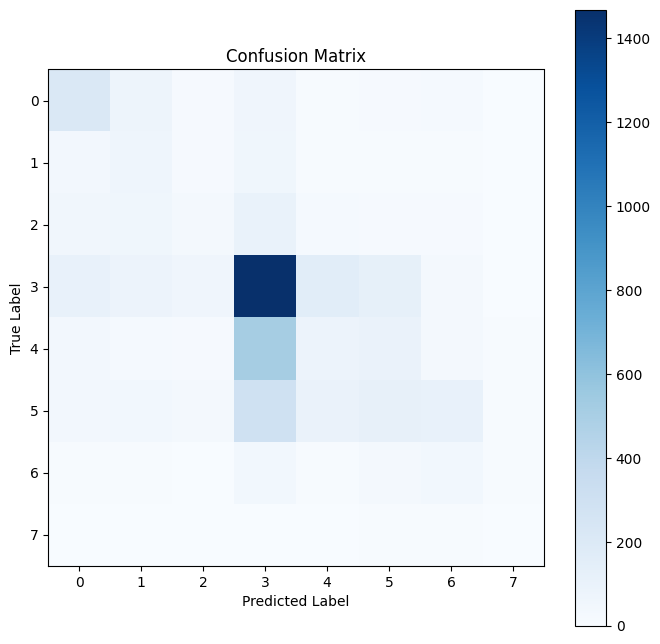

In [79]:
# Define the parameter grid for Grid Search
bst_prms= {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_resampled)),
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'n_estimators': 200,
    'max_depth': 5,
    'num_leaves': 63,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'verbose': -1
}
num_round=200
model = lgb.train(bst_prms,
                 train_data,
                 num_round,
                 valid_sets=test_data,
                 callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=10)])
# y_pred = model.predict(X_test, num_iteration=model.best_iteration)
# y_pred_classes = y_pred.argmax(axis=1)
# label_map = {0: "male", 1: "female"}  # Assuming 0 represents "male" and 1 represents "female"
# y_pred_classes = [label_map[i] for i in y_pred_classes]
# y_test = [label_map[i] for i in y_test]
# print(y_test)
# # Evaluate the model
# print(classification_report(y_test, y_pred_classes))

# #age
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred_probs = y_pred  # Store probabilities for potential later use

# Get predicted class indices
y_pred_classes = y_pred.argmax(axis=1)

# Define label_map (mapping integer labels to class names)
label_map = {
    0: "Class 1",
    1: "Class 2",
    2: "Class 3",
    3: "Class 4",
    4: "Class 5",
    5: "Class 6",
    6: "Class 7",
    7: "Class 8",
}

# Map predicted class indices to class names
y_pred_classes = [label_map[i] for i in y_pred_classes]

# Map true labels to class names (assuming y_test contains integer labels)
y_test = [label_map[i] for i in y_test]

# Evaluate the model
print(classification_report(y_test, y_pred_classes))
#stops here

# Confusion Matrix
cm = confusion_matrix(y_test,y_pred_classes)
plt.figure(figsize=(8, 8))
#sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
print(y_test_classes)
print(y_pred_classes)

['Class 6', 'Class 3', 'Class 4', 'Class 2', 'Class 6', 'Class 1', 'Class 5', 'Class 7', 'Class 4', 'Class 4', 'Class 1', 'Class 7', 'Class 5', 'Class 4', 'Class 7', 'Class 4', 'Class 1', 'Class 4', 'Class 2', 'Class 2', 'Class 4', 'Class 1', 'Class 4', 'Class 1', 'Class 4', 'Class 6', 'Class 8', 'Class 6', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 5', 'Class 4', 'Class 4', 'Class 6', 'Class 6', 'Class 2', 'Class 4', 'Class 2', 'Class 4', 'Class 5', 'Class 4', 'Class 4', 'Class 2', 'Class 4', 'Class 4', 'Class 2', 'Class 6', 'Class 1', 'Class 5', 'Class 3', 'Class 4', 'Class 5', 'Class 1', 'Class 4', 'Class 5', 'Class 4', 'Class 6', 'Class 6', 'Class 4', 'Class 4', 'Class 4', 'Class 6', 'Class 4', 'Class 6', 'Class 5', 'Class 5', 'Class 4', 'Class 3', 'Class 5', 'Class 3', 'Class 3', 'Class 4', 'Class 6', 'Class 4', 'Class 5', 'Class 1', 'Class 4', 'Class 4', 'Class 6', 'Class 4', 'Class 6', 'Class 5', 'Class 4', 'Class 4', 'Class 5', 'Class 4', 'Class 1', 'Class 5', 'Class 4'

In [ ]:
print(np.unique(y_resampled))

['female' 'male']


# **Training the grid_search model and predicting the labels**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


              precision    recall  f1-score   support

           0       0.49      0.77      0.60      2018
           1       0.53      0.46      0.49       927
           2       0.50      0.24      0.33       670
           3       0.45      0.28      0.34       802
           4       0.33      0.01      0.01       359

    accuracy                           0.50      4776
   macro avg       0.46      0.35      0.35      4776
weighted avg       0.48      0.50      0.45      4776



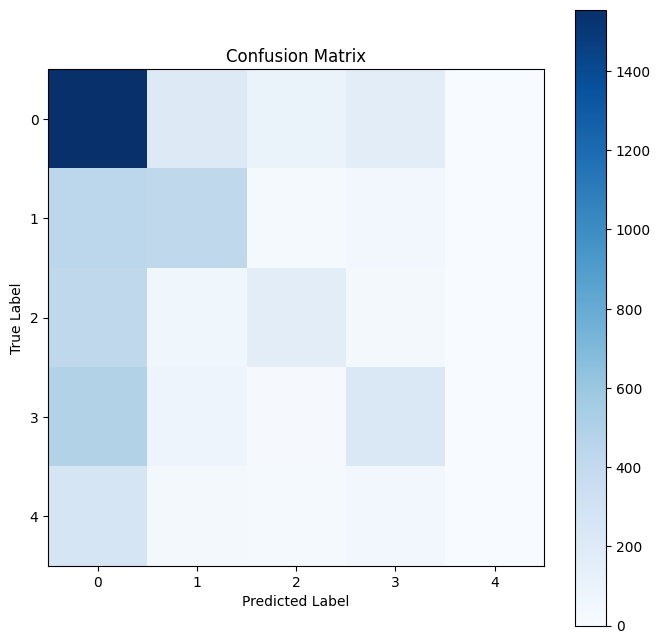

In [ ]:

y_pred=grid_search.predict(X_test)
# Predict on the test data
# y_pred = best_model.predict(X_test)
# Predict probabilities on the test data
# print(y_pred)
# y_pred_classes = y_pred.argmax(axis=1)
# print(y_pred_classes.shape)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 8))
#sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [ ]:
# Define a mapping of numbers to labels
labels = {
    0: 'White',
    1: 'Black',
    2: 'Asian',
    3: 'Indian',
    4: 'Others'
}

# Create a new array with corresponding labels
y_test_labels = np.vectorize(labels.get)(y_test)
y_pred_classes_labels= np.vectorize(labels.get)(y_pred)

#print(y_test_labels)
#print(y_pred_classes_labels)
print(classification_report(y_test_labels,y_pred_classes_labels))

              precision    recall  f1-score   support

       Asian       0.50      0.24      0.33       670
       Black       0.53      0.46      0.49       927
      Indian       0.45      0.28      0.34       802
      Others       0.33      0.01      0.01       359
       White       0.49      0.77      0.60      2018

    accuracy                           0.50      4776
   macro avg       0.46      0.35      0.35      4776
weighted avg       0.48      0.50      0.45      4776



# **Generating a csv file containing the name of each image and its predicted label**

In [80]:
# Get a list of image filenames
#ethnicity
# image_filenames = os.listdir("/content/splitted_dataset/eyes/test")
#gender
# image_filenames = os.listdir("/content/splitted_by_gender/eyes/test")
#age
image_filenames = os.listdir("/content/splitted_by_age/eyes/test")

# Create a DataFrame with image names and predicted labels
df = pd.DataFrame({'Image_Name': image_filenames, 'Predicted_Label': y_pred_classes})

# Save the DataFrame ethnicity to a CSV file
# df.to_csv("predictions_ethnicity_eyes.csv", index=False)
# Save the DataFrame gender to a CSV file
#df.to_csv("predictions_gender_eyes.csv", index=False)
# Save the DataFrame age to a CSV file
df.to_csv("predictions_age_eyes.csv", index=False)

# **MOUTH TRAINING AND TEST VALIDATION**

In [81]:
#Initiliaze the dataset
#gender
# full_train_dataset = EthnicityDataset(root_dir="/content/splitted_by_gender/mouth/train")
# test_dataset = EthnicityDataset(root_dir="/content/splitted_by_gender/mouth/test")
#age
full_train_dataset = EthnicityDataset(root_dir="/content/splitted_by_age/mouth/train")
test_dataset = EthnicityDataset(root_dir="/content/splitted_by_age/mouth/test")




# Extract features for all images in one line
X_train= extract_lbp_features(full_train_dataset)
y_train = full_train_dataset.labels

y_test=test_dataset.labels
X_test = extract_lbp_features(test_dataset)

# **Sampling procedure on the dataset**

In [ ]:
# ros = RandomOverSampler(sampling_strategy={2: 3500, 3: 3500, 4: 3000}, random_state=42)
# rus = RandomUnderSampler(sampling_strategy={0: 5000}, random_state=42)
# # Apply oversampling
# X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
# X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)

# **Changing the weights on the training set and producing the datasets for the models**

---



In [82]:
X_resampled=X_train
y_resampled=y_train
class_weights = compute_class_weight('balanced',  classes=np.unique(y_resampled), y=y_resampled, majority_class_weight_factor=2.5)
#class_weights = compute_class_weight('balanced', classes=np.unique(y_train), )
# Create class weights array for each sample
class_weights = np.array([class_weights[label] for label in y_resampled])

[1594  786 1155 8127 3172 2939  580   68]


In [83]:

#X_resampled, y_resampled
train_data = lgb.Dataset(X_resampled, label=y_resampled,weight=class_weights)
test_data = lgb.Dataset(X_test, label=y_test,free_raw_data=False)

# Ensure X_train and y_train are valid NumPy arrays
if not isinstance(X_resampled, np.ndarray) or not isinstance(y_train, np.ndarray):
    raise ValueError("X_train and y_train must be NumPy arrays")
# Check for empty training data
if len(X_resampled) == 0:
    raise ValueError("X_train cannot be empty")

# **Using GridSearchCV to tune the hyperparameters**

In [ ]:
# Define the parameter grid for Grid Search
param_grid = {
    'learning_rate': [0.05, 0.1, 0.15],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'num_leaves': [31, 63, 127],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}

# Create a LightGBM classifier
model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(np.unique(y_resampled)),
    metric='multi_logloss',
    verbose=-1
)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          cv=2,
                          scoring='accuracy',
                          n_jobs=-1)
# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters
print(f"Best parameters: {grid_search.best_params_}")

# params = {
#     'objective': 'multiclass',  # Adjust for your specific task
#     'num_class': len(np.unique(y_resampled)),# Number of classes in your dataset
#     'metric': 'multi_logloss',
#     'learning_rate':  0.07,
#     'num_leaves': 31,
#     'max_depth': 6,
#     'boosting_type': 'gbdt',
#     'verbose': -1,
#     'feature_fraction': 0.8
#     # ... other hyperparameters
# }
# num_round=110
# #GridSearchCV to tune the hyperparameters
# model = lgb.train(params,
#                  train_data,
#                  num_round,
#                  valid_sets=[train_data,test_data],
#                  callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=10)])

# kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# for fold, (train_index, val_index) in enumerate(kfold.split(X_resampled, y_resampled)):
#     X_train, X_val = X_resampled[train_index], X_resampled[val_index]
#     y_train, y_val = y_resampled[train_index], y_resampled[val_index]

#     train_data = lgb.Dataset(X_train, label=y_train)
#     val_data = lgb.Dataset(X_val, label=y_val)

#     model = lgb.train(params,
#                       train_data,
#                       num_round,
#                       valid_sets=[train_data, val_data],
#                       callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=10)])

#     y_pred = model.predict(X_val, num_iteration=model.best_iteration)
#     y_pred_classes = y_pred.argmax(axis=1)

#     # Evaluate the model on the validation fold
#     print(f"Fold {fold+1} Classification Report:")
#     print(classification_report(y_val, y_pred_classes))

# y_pred = model.predict(X_test, num_iteration=model.best_iteration)
# y_pred_classes = y_pred.argmax(axis=1)
# # Evaluate the model
# print(classification_report(y_test, y_pred_classes))


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'num_leaves': 31, 'subsample': 0.8}


In [ ]:
#Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'num_leaves': 63, 'subsample': 0.8}

# **Training the model on the newly found hyperparameters and predicting the labels**

In [84]:
# Define the parameter grid for Grid Search
bst_prms= {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_resampled)),
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'n_estimators': 200,
    'max_depth': 5,
    'num_leaves': 63,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'verbose': -1
}
num_round=200
model = lgb.train(bst_prms,
                 train_data,
                 num_round,
                 valid_sets=test_data,
                 callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=10)])
# y_pred = model.predict(X_test, num_iteration=model.best_iteration)
# y_pred_classes = y_pred.argmax(axis=1)
# label_map = {0: "male", 1: "female"}  # Assuming 0 represents "male" and 1 represents "female"
# y_pred_classes = [label_map[i] for i in y_pred_classes]
# #age
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred_probs = y_pred  # Store probabilities for potential later use

# Get predicted class indices
y_pred_classes = y_pred.argmax(axis=1)

# Define label_map (mapping integer labels to class names)
label_map = {
    0: "Class 1",
    1: "Class 2",
    2: "Class 3",
    3: "Class 4",
    4: "Class 5",
    5: "Class 6",
    6: "Class 7",
    7: "Class 8",
}

# Map predicted class indices to class names
y_pred_classes = [label_map[i] for i in y_pred_classes]

# Map true labels to class names (assuming y_test contains integer labels)
y_test = [label_map[i] for i in y_test]

# Evaluate the model
print(classification_report(y_test, y_pred_classes))
#stops here


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[10]	valid_0's multi_logloss: 1.71393
[20]	valid_0's multi_logloss: 1.65285
[30]	valid_0's multi_logloss: 1.62084
[40]	valid_0's multi_logloss: 1.59858
[50]	valid_0's multi_logloss: 1.58414
[60]	valid_0's multi_logloss: 1.5737
[70]	valid_0's multi_logloss: 1.56509
[80]	valid_0's multi_logloss: 1.55754
[90]	valid_0's multi_logloss: 1.55215
[100]	valid_0's multi_logloss: 1.5478
[110]	valid_0's multi_logloss: 1.54454
[120]	valid_0's multi_logloss: 1.54194
[130]	valid_0's multi_logloss: 1.53938
[140]	valid_0's multi_logloss: 1.53676
[150]	valid_0's multi_logloss: 1.53429
[160]	valid_0's multi_logloss: 1.53177
[170]	valid_0's multi_logloss: 1.5302
[180]	valid_0's multi_logloss: 1.52875
[190]	valid_0's multi_logloss: 1.52655
[200]	valid_0's multi_logloss: 1.52485
Did not meet early stopping. Best iteration is:
[200]	valid_0's multi_logloss: 1.52485
              precision    recall  f1-score   support

     Class 1       0.38      

['female', 'male', 'female', 'male', 'male', 'male', 'female', 'female', 'female', 'male', 'female', 'female', 'female', 'male', 'male', 'male', 'male', 'male', 'female', 'male', 'male', 'male', 'male', 'male', 'female', 'female', 'female', 'female', 'male', 'male', 'female', 'female', 'female', 'male', 'female', 'female', 'male', 'female', 'male', 'female', 'female', 'female', 'male', 'male', 'male', 'male', 'female', 'female', 'male', 'male', 'male', 'female', 'male', 'female', 'male', 'female', 'female', 'male', 'female', 'male', 'female', 'male', 'female', 'female', 'female', 'male', 'male', 'female', 'female', 'female', 'female', 'female', 'female', 'male', 'female', 'male', 'male', 'male', 'male', 'male', 'male', 'female', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'female', 'male', 'male', 'female', 'male', 'female', 'male', 'male', 'female', 'female', 'male', 'male', 'female', 'female', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'female', 'male

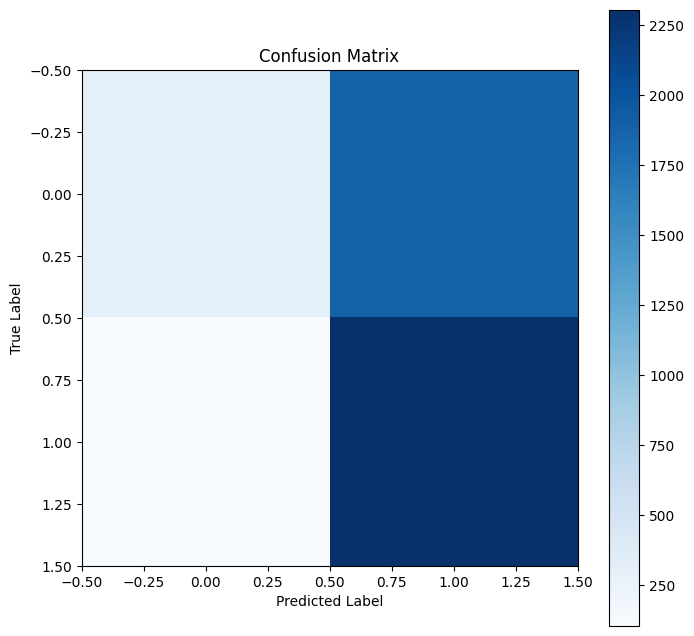

In [49]:
y_test = [label_map[i] for i in y_test]
print(y_test)
# Evaluate the model
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_test,y_pred_classes)
plt.figure(figsize=(8, 8))
#sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# **Training the grid_search model and predicting the labels**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

              precision    recall  f1-score   support

           0       0.46      0.85      0.60      2018
           1       0.42      0.27      0.33       927
           2       0.43      0.12      0.19       670
           3       0.34      0.11      0.16       802
           4       0.00      0.00      0.00       359

    accuracy                           0.45      4776
   macro avg       0.33      0.27      0.26      4776
weighted avg       0.39      0.45      0.37      4776



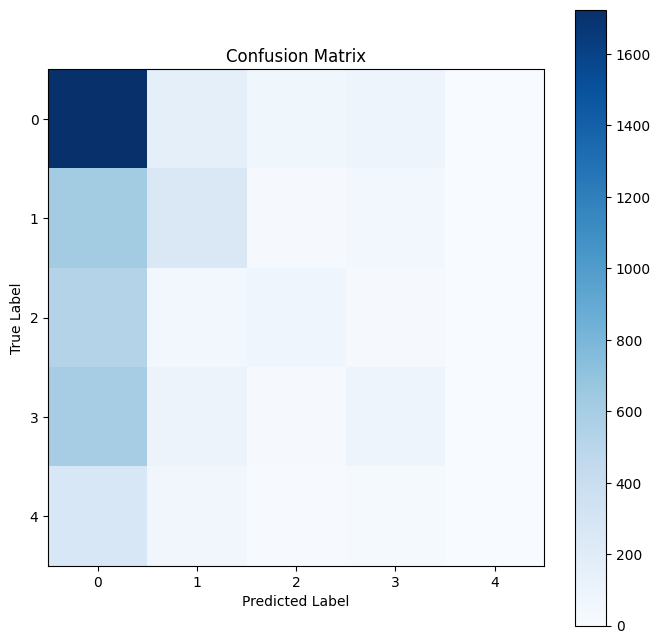

In [ ]:

y_pred=grid_search.predict(X_test)
# Predict on the test data
# y_pred = best_model.predict(X_test)
# Predict probabilities on the test data
# print(y_pred)
# y_pred_classes = y_pred.argmax(axis=1)
# print(y_pred_classes.shape)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 8))
#sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



In [ ]:
# Define a mapping of numbers to labels
labels = {
    0: 'White',
    1: 'Black',
    2: 'Asian',
    3: 'Indian',
    4: 'Others'
}

# Create a new array with corresponding labels
y_test_labels = np.vectorize(labels.get)(y_test)
y_pred_classes_labels= np.vectorize(labels.get)(y_pred)

#print(y_test_labels)
#print(y_pred_classes_labels)
print(classification_report(y_test_labels,y_pred_classes_labels))

              precision    recall  f1-score   support

       Asian       0.43      0.12      0.19       670
       Black       0.42      0.27      0.33       927
      Indian       0.34      0.11      0.16       802
      Others       0.00      0.00      0.00       359
       White       0.46      0.85      0.60      2018

    accuracy                           0.45      4776
   macro avg       0.33      0.27      0.26      4776
weighted avg       0.39      0.45      0.37      4776



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# **Generating a csv file containing the name of each image and its predicted label**

In [85]:
# Get a list of image filenames
#ethnicity
# image_filenames = os.listdir("/content/splitted_dataset/mouth/test")
#gender
# image_filenames = os.listdir("/content/splitted_by_gender/mouth/test")
#age
image_filenames = os.listdir("/content/splitted_by_age/mouth/test")

# Create a DataFrame with image names and predicted labels
df = pd.DataFrame({'Image_Name': image_filenames, 'Predicted_Label': y_pred_classes})

# Save the DataFrame ethnicity to a CSV file
# df.to_csv("predictions_mouth.csv", index=False)
# Save the DataFrame gender to a CSV file
# df.to_csv("predictions_gender_mouth.csv", index=False)
# Save the DataFrame age to a CSV file
df.to_csv("predictions_age_mouth.csv", index=False)

[5000 3000 3500 3500 3000]
<class 'lightgbm.basic.Dataset'>
Training until validation scores don't improve for 20 rounds
[20]	training's multi_logloss: 1.1752	valid_1's multi_logloss: 1.40524
[40]	training's multi_logloss: 1.10698	valid_1's multi_logloss: 1.39561
[60]	training's multi_logloss: 1.0638	valid_1's multi_logloss: 1.3964
Early stopping, best iteration is:
[43]	training's multi_logloss: 1.09835	valid_1's multi_logloss: 1.39553
(4776, 5)
(4776,)
              precision    recall  f1-score   support

           0       0.44      0.97      0.61      2018
           1       0.54      0.13      0.21       927
           2       0.48      0.06      0.10       670
           3       0.47      0.03      0.05       802
           4       0.00      0.00      0.00       359

    accuracy                           0.45      4776
   macro avg       0.39      0.24      0.19      4776
weighted avg       0.44      0.45      0.32      4776



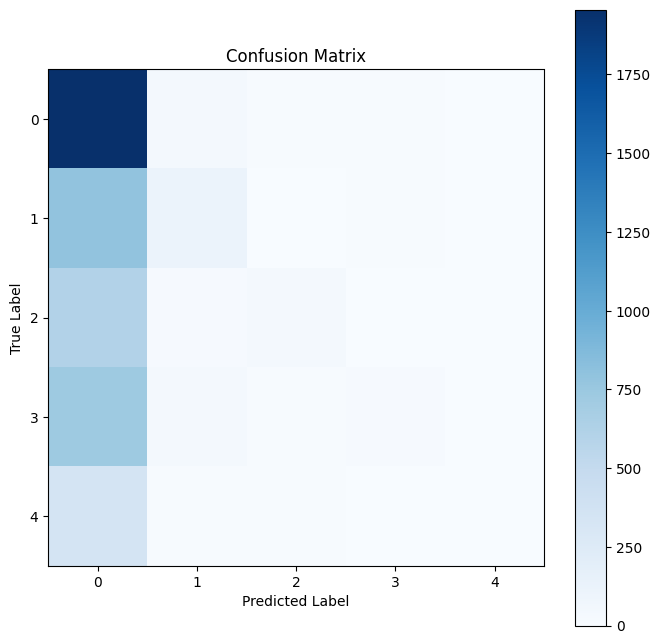

In [ ]:


# Define hyperparameters and objective for LightGBM
params = {
    'objective': 'multiclass',  # Adjust for your specific task
    'num_class': len(np.unique(y_train)),# Number of classes in your dataset
    'metric': 'multi_logloss',
    'learning_rate':  0.05,
    'num_leaves': 31,
    'max_depth': 6,
    'boosting_type': 'gbdt',
    'verbose': -1
    # ... other hyperparameters
}
print(type(train_data))
num_round=100
model = lgb.train(params,
                 train_data,
                 num_round,
                 valid_sets=[train_data,test_data],
                 callbacks=[lgb.early_stopping(stopping_rounds=20), lgb.log_evaluation(period=20)])

y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print(y_pred.shape)
y_pred_classes = y_pred.argmax(axis=1)
print(y_pred_classes.shape)

# Evaluate the model
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 8))
#sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
# X_resampled=X_train
# y_resampled=y_train

for fold, (train_index, val_index) in enumerate(kfold.split(X_resampled, y_resampled)):
    X_train, X_val = X_resampled[train_index], X_resampled[val_index]
    y_train, y_val = y_resampled[train_index], y_resampled[val_index]

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)

    model = lgb.train(params,
                      train_data,
                      num_round,
                      valid_sets=[train_data, val_data],
                      callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=10)])

    y_pred = model.predict(X_val, num_iteration=model.best_iteration)
    y_pred_classes = y_pred.argmax(axis=1)

    # Evaluate the model on the validation fold
    print(f"Fold {fold+1} Classification Report:")
    print(classification_report(y_val, y_pred_classes))
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred_classes = y_pred.argmax(axis=1)
# Evaluate the model
print(classification_report(y_test, y_pred_classes))

Training until validation scores don't improve for 10 rounds
[10]	training's multi_logloss: 1.46412	valid_1's multi_logloss: 1.48301
[20]	training's multi_logloss: 1.39373	valid_1's multi_logloss: 1.43202
[30]	training's multi_logloss: 1.34464	valid_1's multi_logloss: 1.40112
[40]	training's multi_logloss: 1.3057	valid_1's multi_logloss: 1.38077
[50]	training's multi_logloss: 1.27569	valid_1's multi_logloss: 1.36495
[60]	training's multi_logloss: 1.2526	valid_1's multi_logloss: 1.35459
[70]	training's multi_logloss: 1.23084	valid_1's multi_logloss: 1.345
[80]	training's multi_logloss: 1.20891	valid_1's multi_logloss: 1.33494
[90]	training's multi_logloss: 1.18743	valid_1's multi_logloss: 1.3246
[100]	training's multi_logloss: 1.16393	valid_1's multi_logloss: 1.31361
Did not meet early stopping. Best iteration is:
[100]	training's multi_logloss: 1.16393	valid_1's multi_logloss: 1.31361
Fold 1 Classification Report:
              precision    recall  f1-score   support

           0     

In [ ]:
# Define the parameter grid for Grid Search
bst_prms= {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_resampled)),
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'n_estimators': 200,
    'max_depth': 5,
    'num_leaves': 63,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'verbose': -1
}
num_round=200
model = lgb.train(bst_prms,
                 train_data,
                 num_round,
                 valid_sets=test_data,
                 callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=10)])
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred_classes = y_pred.argmax(axis=1)

# Evaluate the model
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_test,y_pred_classes)
plt.figure(figsize=(8, 8))
#sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:

# Define hyperparameters and objective for LightGBM
params = {
    'objective': 'multiclass',  # Adjust for your specific task
    'num_class': len(np.unique(y_resampled)),# Number of classes in your dataset
    'metric': 'multi_logloss',
    'learning_rate':  0.07,
    'num_leaves': 32,
    'max_depth': 7,
    'boosting_type': 'gbdt',
    'verbose': -1
    # ... other hyperparameters
}
num_round=100
# model = lgb.train(params,
#                  train_data,
#                  num_round,
#                  valid_sets=[train_data,test_data],
#                  callbacks=[lgb.early_stopping(stopping_rounds=15), lgb.log_evaluation(period=15)])

# y_pred = model.predict(X_test, num_iteration=model.best_iteration)
# print(y_pred.shape)
# y_pred_classes = y_pred.argmax(axis=1)
# print(y_pred_classes.shape)

# # Evaluate the model
# print(classification_report(y_test, y_pred_classes))

# # Confusion Matrix
# cm = confusion_matrix(y_test, y_pred_classes)
# plt.figure(figsize=(8, 8))
# #sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
# plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
# plt.title('Confusion Matrix')
# plt.colorbar()
# plt.xlabel('Predicted Label')
# plt.ylabel('True Label')
# plt.show()




from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
# X_resampled=X_train
# y_resampled=y_train

for fold, (train_index, val_index) in enumerate(kfold.split(X_resampled, y_resampled)):
    X_train, X_val = X_resampled[train_index], X_resampled[val_index]
    y_train, y_val = y_resampled[train_index], y_resampled[val_index]

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)

    model = lgb.train(params,
                      train_data,
                      num_round,
                      valid_sets=[train_data, val_data],
                      callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=10)])

    y_pred = model.predict(X_val, num_iteration=model.best_iteration)
    y_pred_classes = y_pred.argmax(axis=1)

    # Evaluate the model on the validation fold
    print(f"Fold {fold+1} Classification Report:")
    print(classification_report(y_val, y_pred_classes))

y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred_classes = y_pred.argmax(axis=1)
# Evaluate the model
print(classification_report(y_test, y_pred_classes))

[7846 3529 2514 3050 1316]
[7846 3529 2514 3050 2632]
Training until validation scores don't improve for 10 rounds
[10]	training's multi_logloss: 1.37706	valid_1's multi_logloss: 1.43414
[20]	training's multi_logloss: 1.3187	valid_1's multi_logloss: 1.41065
[30]	training's multi_logloss: 1.27743	valid_1's multi_logloss: 1.39822
[40]	training's multi_logloss: 1.24333	valid_1's multi_logloss: 1.39272
[50]	training's multi_logloss: 1.21111	valid_1's multi_logloss: 1.38591
[60]	training's multi_logloss: 1.18378	valid_1's multi_logloss: 1.38218
[70]	training's multi_logloss: 1.15845	valid_1's multi_logloss: 1.37755
[80]	training's multi_logloss: 1.134	valid_1's multi_logloss: 1.37572
[90]	training's multi_logloss: 1.11097	valid_1's multi_logloss: 1.37358
[100]	training's multi_logloss: 1.08982	valid_1's multi_logloss: 1.37001
Did not meet early stopping. Best iteration is:
[100]	training's multi_logloss: 1.08982	valid_1's multi_logloss: 1.37001
Fold 1 Classification Report:
              pr

In [ ]:
print(len(y_test),len(y_pred_classes),len(y_pred))

4776 4776 4776


In [ ]:
# Define a mapping of numbers to labels
labels = {
    0: 'White',
    1: 'Black',
    2: 'Asian',
    3: 'Indian',
    4: 'Others'
}

# Create a new array with corresponding labels
y_test_labels = np.vectorize(labels.get)(y_test)
y_pred_classes_labels= np.vectorize(labels.get)(y_pred_classes)

#print(y_test_labels)
#print(y_pred_classes_labels)
print(classification_report(y_test_labels,y_pred_classes_labels))

              precision    recall  f1-score   support

       Asian       0.41      0.16      0.23       670
       Black       0.41      0.29      0.34       927
      Indian       0.32      0.15      0.21       802
      Others       0.24      0.04      0.07       359
       White       0.47      0.80      0.60      2018

    accuracy                           0.45      4776
   macro avg       0.37      0.29      0.29      4776
weighted avg       0.41      0.45      0.39      4776



# **NOSE TRAINING AND TEST VALIDATION**

In [90]:
#Initialize the dataset
#gender
# full_train_dataset = EthnicityDataset(root_dir="/content/splitted_by_gender/nose/train")
# test_dataset = EthnicityDataset(root_dir="/content/splitted_by_gender/nose/test")

#age
full_train_dataset = EthnicityDataset(root_dir="/content/splitted_by_age/nose/train")
test_dataset = EthnicityDataset(root_dir="/content/splitted_by_age/nose/test")


# Extract features for all images in one line
X_train= extract_lbp_features(full_train_dataset)
y_train = full_train_dataset.labels
X_test = extract_lbp_features(test_dataset)
y_test=test_dataset.labels


# **Sampling procedure on the dataset**

In [57]:
# ros = RandomOverSampler(sampling_strategy={2: 3500, 3: 3500, 4: 3000}, random_state=42)
# rus = RandomUnderSampler(sampling_strategy={0: 5000}, random_state=42)
# # Apply oversampling
# X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
# X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)

# **Changing the weights on the training set and producing the datasets for the models**

---



In [91]:
X_resampled=X_train
y_resampled=y_train

class_weights = compute_class_weight('balanced',  classes=np.unique(y_resampled), y=y_resampled, majority_class_weight_factor=1.5)
#class_weights = compute_class_weight('balanced', classes=np.unique(y_train), )
# Create class weights array for each sample
class_weights = np.array([class_weights[label] for label in y_resampled])


#X_resampled, y_resampled
train_data = lgb.Dataset(X_resampled, label=y_resampled,weight=class_weights)
test_data = lgb.Dataset(X_test, label=y_test,free_raw_data=False)

# Ensure X_train and y_train are valid NumPy arrays
if not isinstance(X_resampled, np.ndarray) or not isinstance(y_train, np.ndarray):
    raise ValueError("X_train and y_train must be NumPy arrays")
# Check for empty training data
if len(X_resampled) == 0:
    raise ValueError("X_train cannot be empty")

[1594  786 1151 8131 3172 2939  584   64]


# **Using GridSearchCV to tune the hyperparameters**

In [53]:
# Define the parameter grid for Grid Search
param_grid = {
    'learning_rate': [0.05, 0.1, 0.15],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'num_leaves': [31, 63, 127],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9]
}

# Create a LightGBM classifier
model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(np.unique(y_resampled)),
    metric='multi_logloss',
    verbose=-1
)

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          cv=2,
                          scoring='accuracy',
                          n_jobs=-1)
# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Print the best parameters
print(f"Best parameters: {grid_search.best_params_}")

# params = {
#     'objective': 'multiclass',  # Adjust for your specific task
#     'num_class': len(np.unique(y_resampled)),# Number of classes in your dataset
#     'metric': 'multi_logloss',
#     'learning_rate':  0.07,
#     'num_leaves': 31,
#     'max_depth': 6,
#     'boosting_type': 'gbdt',
#     'verbose': -1,
#     'feature_fraction': 0.8
#     # ... other hyperparameters
# }
# num_round=110
# #GridSearchCV to tune the hyperparameters
# model = lgb.train(params,
#                  train_data,
#                  num_round,
#                  valid_sets=[train_data,test_data],
#                  callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=10)])

# kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# for fold, (train_index, val_index) in enumerate(kfold.split(X_resampled, y_resampled)):
#     X_train, X_val = X_resampled[train_index], X_resampled[val_index]
#     y_train, y_val = y_resampled[train_index], y_resampled[val_index]

#     train_data = lgb.Dataset(X_train, label=y_train)
#     val_data = lgb.Dataset(X_val, label=y_val)

#     model = lgb.train(params,
#                       train_data,
#                       num_round,
#                       valid_sets=[train_data, val_data],
#                       callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=10)])

#     y_pred = model.predict(X_val, num_iteration=model.best_iteration)
#     y_pred_classes = y_pred.argmax(axis=1)

#     # Evaluate the model on the validation fold
#     print(f"Fold {fold+1} Classification Report:")
#     print(classification_report(y_val, y_pred_classes))

# y_pred = model.predict(X_test, num_iteration=model.best_iteration)
# y_pred_classes = y_pred.argmax(axis=1)
# # Evaluate the model
# print(classification_report(y_test, y_pred_classes))


/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
#Best parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'num_leaves': 63, 'subsample': 0.8}

# **Training the model on the newly found hyperparameters and predicting the labels**

In [92]:
# Define the parameter grid for Grid Search
bst_prms= {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_resampled)),
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'n_estimators': 200,
    'max_depth': 5,
    'num_leaves': 63,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'verbose': -1
}
num_round=200
model = lgb.train(bst_prms,
                 train_data,
                 num_round,
                 valid_sets=test_data,
                 callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=10)])
#gender
# y_pred = model.predict(X_test, num_iteration=model.best_iteration)
# y_pred_classes = y_pred.argmax(axis=1)
# label_map = {0: "male", 1: "female"}  # Assuming 0 represents "male" and 1 represents "female"
# y_pred_classes = [label_map[i] for i in y_pred_classes]

#age
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred_probs = y_pred  # Store probabilities for potential later use

# Get predicted class indices
y_pred_classes = y_pred.argmax(axis=1)

# Define label_map (mapping integer labels to class names)
label_map = {
    0: "Class 1",
    1: "Class 2",
    2: "Class 3",
    3: "Class 4",
    4: "Class 5",
    5: "Class 6",
    6: "Class 7",
    7: "Class 8",
}

# Map predicted class indices to class names
y_pred_classes = [label_map[i] for i in y_pred_classes]
#stops here


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 10 rounds
[10]	valid_0's multi_logloss: 1.80931
[20]	valid_0's multi_logloss: 1.73621
[30]	valid_0's multi_logloss: 1.69611
[40]	valid_0's multi_logloss: 1.67069
[50]	valid_0's multi_logloss: 1.65458
[60]	valid_0's multi_logloss: 1.64352
[70]	valid_0's multi_logloss: 1.63616
[80]	valid_0's multi_logloss: 1.63052
[90]	valid_0's multi_logloss: 1.62563
[100]	valid_0's multi_logloss: 1.6216
[110]	valid_0's multi_logloss: 1.61848
[120]	valid_0's multi_logloss: 1.61531
[130]	valid_0's multi_logloss: 1.61114
[140]	valid_0's multi_logloss: 1.60782
[150]	valid_0's multi_logloss: 1.60464
[160]	valid_0's multi_logloss: 1.60271
[170]	valid_0's multi_logloss: 1.60034
[180]	valid_0's multi_logloss: 1.59786
[190]	valid_0's multi_logloss: 1.59574
[200]	valid_0's multi_logloss: 1.59397
Did not meet early stopping. Best iteration is:
[200]	valid_0's multi_logloss: 1.59397


In [64]:
print(y_test)
print(y_pred_classes)

[1 1 1 ... 0 0 0]
['male', 'female', 'female', 'male', 'female', 'male', 'female', 'male', 'male', 'female', 'male', 'male', 'female', 'male', 'male', 'female', 'male', 'male', 'male', 'male', 'female', 'male', 'male', 'male', 'male', 'male', 'female', 'male', 'male', 'male', 'female', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'female', 'male', 'male', 'male', 'female', 'female', 'female', 'female', 'male', 'female', 'male', 'male', 'male', 'male', 'female', 'male', 'male', 'male', 'male', 'male', 'male', 'female', 'female', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'female', 'male', 'male', 'female', 'female', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'male', 'female', 'male', 'male', 'male', 'male', 'male', 'female', 'male', 'male', 'female', 'male', 'female', 'male', 'female', 'male', 'female', 'male', 'male', 'female', 'male', 'male', 'female', 'male', 'male', '

              precision    recall  f1-score   support

     Class 1       0.30      0.44      0.36       399
     Class 2       0.15      0.21      0.17       197
     Class 3       0.14      0.06      0.09       281
     Class 4       0.57      0.64      0.60      2040
     Class 5       0.27      0.14      0.19       794
     Class 6       0.32      0.26      0.29       735
     Class 7       0.15      0.32      0.21       145
     Class 8       0.11      0.21      0.14        19

    accuracy                           0.41      4610
   macro avg       0.25      0.29      0.26      4610
weighted avg       0.40      0.41      0.40      4610



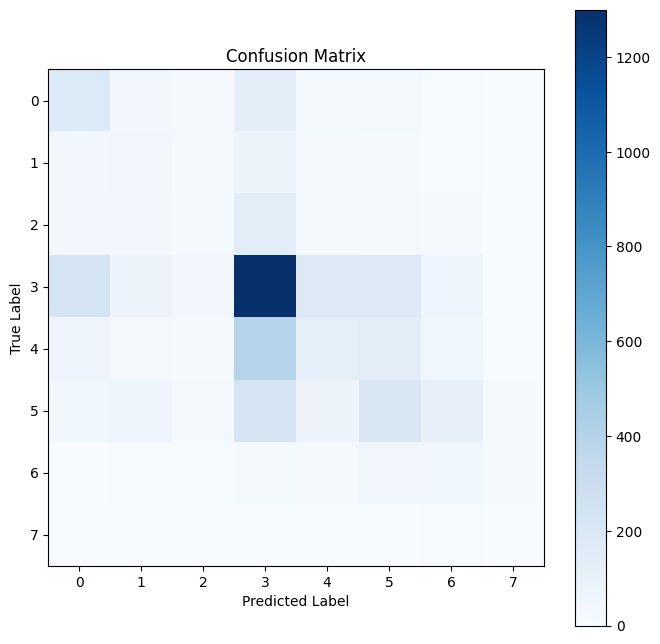

In [93]:
y_test = [label_map[i] for i in y_test]
# Evaluate the model
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_test,y_pred_classes)
plt.figure(figsize=(8, 8))
#sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# **Training the grid_search model and predicting the labels**

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_tags.py:354: FutureWarning: The LGBMClassifier or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metri

              precision    recall  f1-score   support

           0       0.47      0.85      0.61      2018
           1       0.41      0.32      0.36       927
           2       0.47      0.15      0.22       670
           3       0.30      0.07      0.12       802
           4       0.00      0.00      0.00       359

    accuracy                           0.45      4776
   macro avg       0.33      0.28      0.26      4776
weighted avg       0.40      0.45      0.38      4776



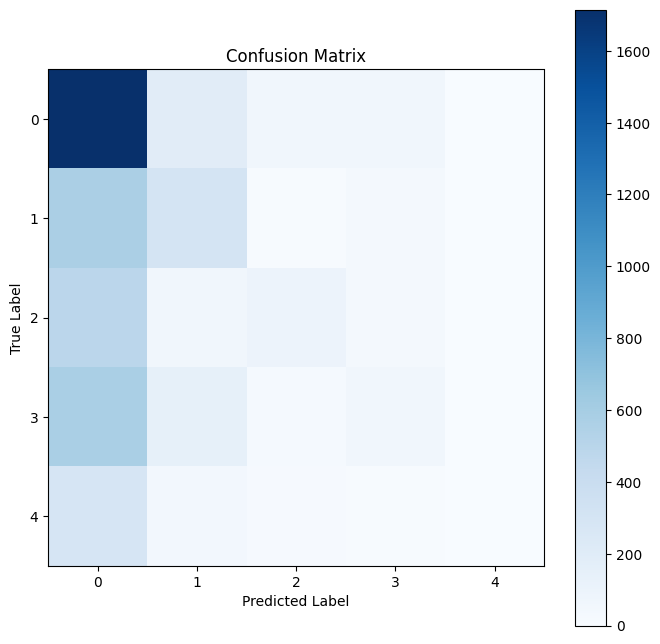

In [ ]:

y_pred=grid_search.predict(X_test)
# Predict on the test data
# y_pred = best_model.predict(X_test)
# Predict probabilities on the test data
# print(y_pred)
# y_pred_classes = y_pred.argmax(axis=1)
# print(y_pred_classes.shape)

# Evaluate the model
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 8))
#sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()



# **Generating a csv file containing the name of each image and its predicted label**

In [94]:
# Get a list of image filenames
#ethnicity
# image_filenames = os.listdir("/content/splitted_dataset/nose/test")
#gender
# image_filenames = os.listdir("/content/splitted_by_gender/nose/test")
#age
image_filenames = os.listdir("/content/splitted_by_age/nose/test")

# Create a DataFrame with image names and predicted labels
df = pd.DataFrame({'Image_Name': image_filenames, 'Predicted_Label': y_pred_classes})

# Save the DataFrame ethnicity to a CSV file
# df.to_csv("predictions_nose.csv", index=False)
# Save the DataFrame gender to a CSV file
# df.to_csv("predictions_gender_nose.csv", index=False)
# Save the DataFrame age to a CSV file
df.to_csv("predictions_age_nose.csv", index=False)

[5000 3000 3500 3500 3000]
<class 'lightgbm.basic.Dataset'>
Training until validation scores don't improve for 20 rounds
[20]	training's multi_logloss: 1.1752	valid_1's multi_logloss: 1.40524
[40]	training's multi_logloss: 1.10698	valid_1's multi_logloss: 1.39561
[60]	training's multi_logloss: 1.0638	valid_1's multi_logloss: 1.3964
Early stopping, best iteration is:
[43]	training's multi_logloss: 1.09835	valid_1's multi_logloss: 1.39553
(4776, 5)
(4776,)
              precision    recall  f1-score   support

           0       0.44      0.97      0.61      2018
           1       0.54      0.13      0.21       927
           2       0.48      0.06      0.10       670
           3       0.47      0.03      0.05       802
           4       0.00      0.00      0.00       359

    accuracy                           0.45      4776
   macro avg       0.39      0.24      0.19      4776
weighted avg       0.44      0.45      0.32      4776



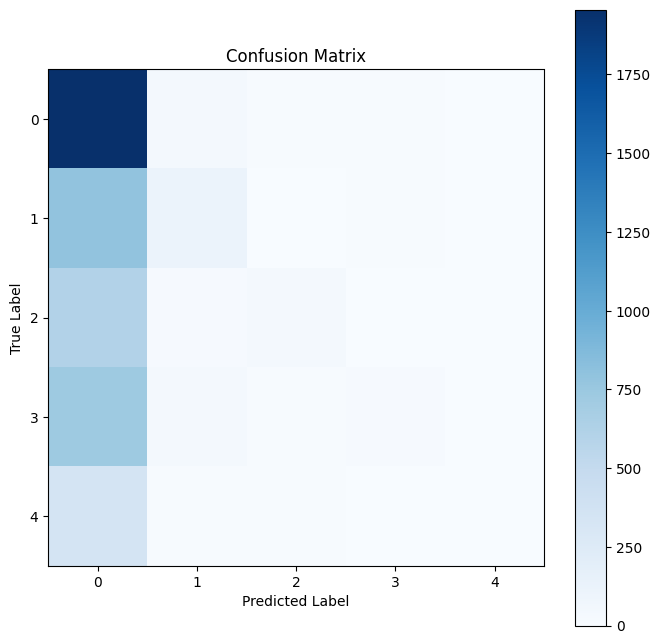

In [ ]:


# Define hyperparameters and objective for LightGBM
params = {
    'objective': 'multiclass',  # Adjust for your specific task
    'num_class': len(np.unique(y_train)),# Number of classes in your dataset
    'metric': 'multi_logloss',
    'learning_rate':  0.05,
    'num_leaves': 31,
    'max_depth': 6,
    'boosting_type': 'gbdt',
    'verbose': -1
    # ... other hyperparameters
}
print(type(train_data))
num_round=100
model = lgb.train(params,
                 train_data,
                 num_round,
                 valid_sets=[train_data,test_data],
                 callbacks=[lgb.early_stopping(stopping_rounds=20), lgb.log_evaluation(period=20)])

y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print(y_pred.shape)
y_pred_classes = y_pred.argmax(axis=1)
print(y_pred_classes.shape)

# Evaluate the model
print(classification_report(y_test, y_pred_classes))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 8))
#sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [ ]:
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
# X_resampled=X_train
# y_resampled=y_train

for fold, (train_index, val_index) in enumerate(kfold.split(X_resampled, y_resampled)):
    X_train, X_val = X_resampled[train_index], X_resampled[val_index]
    y_train, y_val = y_resampled[train_index], y_resampled[val_index]

    train_data = lgb.Dataset(X_train, label=y_train)
    val_data = lgb.Dataset(X_val, label=y_val)

    model = lgb.train(params,
                      train_data,
                      num_round,
                      valid_sets=[train_data, val_data],
                      callbacks=[lgb.early_stopping(stopping_rounds=10), lgb.log_evaluation(period=10)])

    y_pred = model.predict(X_val, num_iteration=model.best_iteration)
    y_pred_classes = y_pred.argmax(axis=1)

    # Evaluate the model on the validation fold
    print(f"Fold {fold+1} Classification Report:")
    print(classification_report(y_val, y_pred_classes))
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred_classes = y_pred.argmax(axis=1)
# Evaluate the model
print(classification_report(y_test, y_pred_classes))

Training until validation scores don't improve for 10 rounds
[10]	training's multi_logloss: 1.46412	valid_1's multi_logloss: 1.48301
[20]	training's multi_logloss: 1.39373	valid_1's multi_logloss: 1.43202
[30]	training's multi_logloss: 1.34464	valid_1's multi_logloss: 1.40112
[40]	training's multi_logloss: 1.3057	valid_1's multi_logloss: 1.38077
[50]	training's multi_logloss: 1.27569	valid_1's multi_logloss: 1.36495
[60]	training's multi_logloss: 1.2526	valid_1's multi_logloss: 1.35459
[70]	training's multi_logloss: 1.23084	valid_1's multi_logloss: 1.345
[80]	training's multi_logloss: 1.20891	valid_1's multi_logloss: 1.33494
[90]	training's multi_logloss: 1.18743	valid_1's multi_logloss: 1.3246
[100]	training's multi_logloss: 1.16393	valid_1's multi_logloss: 1.31361
Did not meet early stopping. Best iteration is:
[100]	training's multi_logloss: 1.16393	valid_1's multi_logloss: 1.31361
Fold 1 Classification Report:
              precision    recall  f1-score   support

           0     